## Creating the dataset and training the model

In [26]:
# import the packages
import os
import pandas as pd
import numpy as np

import torch 
import torchaudio
from torch.utils.data import DataLoader, random_split

import IPython.display as ipd
import matplotlib.pyplot as plt

from utils import *

### Checking if cuda is available

In [27]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A500 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Creating a Custom Dataset

In [29]:
#load metadata df 
current_dir = os.getcwd() 
file_name = "Dataset\\metadata.csv"
file_path = os.path.join(current_dir, file_name) 
df_metadata = pd.read_csv(file_path)
display(df_metadata)

,file_id,original_file_id,english_cname,path,class_id
0,1,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
1,2,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
2,3,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
3,4,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
4,5,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
...,...,...,...,...,...
3543,3544,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75
3544,3545,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75
3545,3546,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75
3546,3547,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75


In [13]:
#create a dataset
birdsong_dataset = AudioDataSet(df_metadata=df_metadata)

#create training, validation, and test set. (60, 20, 20) split
train_size = int(0.6 * len(birdsong_dataset))
val_size = int(0.2 * len(birdsong_dataset))
test_size = len(birdsong_dataset) - train_size - val_size

#use random_split to perform the split 
train_dataset, val_dataset, test_dataset = random_split(birdsong_dataset, [train_size, val_size, test_size])

#print the lengths of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 2128
Validation set size: 709
Test set size: 711


In [14]:
#create the training, validation and test data loaders  (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Shape of spectrograms: torch.Size([16, 1, 401, 552]), Class ids: tensor([11, 53, 18, 78, 10, 33, 32, 38, 61, 11, 22, 69, 20, 69, 11, 56])


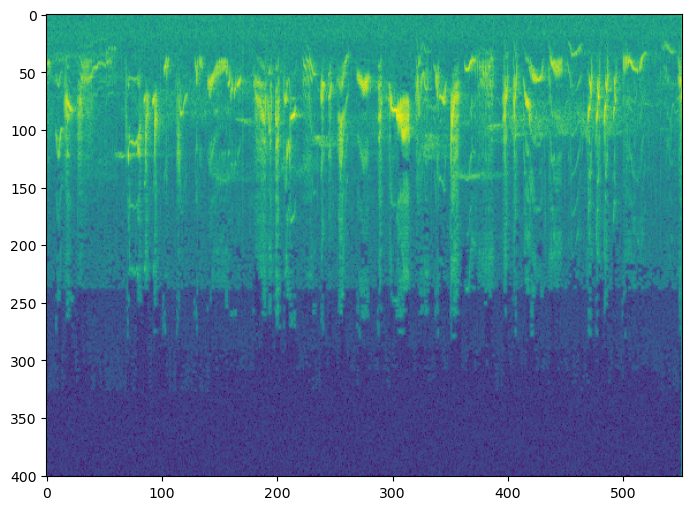

In [36]:
#test data loaders 
spectrograms, class_id = next(iter(train_dataloader)) 
print(f"Shape of spectrograms: {spectrograms.size()}, Class ids: {class_id}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrograms[0,0,:,:].numpy())

### Creating the model
Each batch has a shape of (batch_size, num_channels, frequency_bands, time_steps). This means that each input (each spectrogram) is of size frequency_bands x time_steps which in our case is 401 x 552 = 221352.

The audio has not been transformed to spectrogram images so now we can use standard image classification techniques. This means we are going to use a CNN model to classify the spectrogram images. (image classification paper/source) 


In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [45]:
class BirdAudioClassifier(nn.Module): 
    def __init__(self, num_classes=88): 
        super().__init__() 
        #define the different layers 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) #number of input channels, number of output channels (number of filters that will be applied), 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        #define max pooling 
        self.max_pool = nn.MaxPool2d(2, 2)
        #layer to flatten the output 
        self.flatten = nn.Flatten() 
        #fully connected layer for classification 
        self.fc1 = nn.Linear(411648, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    #implement the forward propagation through the network
    def forward(self, x): 
        #first convolutional layer + relu + max pool layer
        x = self.max_pool(F.relu(self.conv1(x)))
        #second convolutional layer + relu + max pool layer
        x = self.max_pool(F.relu(self.conv2(x)))
        #third convolutional layer + relu + max pool layer
        x = self.max_pool(F.relu(self.conv3(x)))
        #flatten the output from the convolutional layer 
        x = self.flatten(x) 
        #first fully connected layer 
        x = F.relu(self.fc1(x)) 
        #second fully connected layer 
        x = self.fc2(x) 
        #softmax activation function to convert the logits to log probabilities
        x = F.log_softmax(x, dim=1)
        return x

In [46]:
#testing 
num_bird_classes = 88
test_model = BirdAudioClassifier(num_classes=num_bird_classes).to(device)
print(test_model)

BirdAudioClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=411648, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=88, bias=True)
)


In [47]:
#testing the model with input (for prediction) 
spectrograms_test = spectrograms.to(device) 
# Set the model to evaluation mode
test_model.eval()
# Forward pass to get predictions
with torch.no_grad():
    predictions = test_model(spectrograms_test)

# 'predictions' now contains the log probabilities for each class
# You can use torch.exp to convert them to probabilities if needed
probabilities = torch.exp(predictions)
# Print or use the results as needed
print(probabilities)

# Find the maximum probability and its corresponding index along the second dimension (num_classes)
max_probabilities, predicted_classes = torch.max(probabilities, dim=1)

# 'max_probabilities' contains the highest probability for each output tensor in the batch
# 'predicted_classes' contains the index of the class with the highest probability for each output tensor

# Print or use the results as needed
print(max_probabilities)
print(predicted_classes)

tensor([[0.0129, 0.0114, 0.0048,  ..., 0.0183, 0.0291, 0.0098],
        [0.0138, 0.0083, 0.0057,  ..., 0.0194, 0.0348, 0.0079],
        [0.0240, 0.0100, 0.0136,  ..., 0.0223, 0.0239, 0.0117],
        ...,
        [0.0125, 0.0098, 0.0063,  ..., 0.0204, 0.0362, 0.0097],
        [0.0144, 0.0111, 0.0056,  ..., 0.0202, 0.0311, 0.0094],
        [0.0128, 0.0085, 0.0062,  ..., 0.0188, 0.0351, 0.0074]],
       device='cuda:0')
tensor([0.0843, 0.0854, 0.0546, 0.0689, 0.0550, 0.0794, 0.1112, 0.0760, 0.0644,
        0.0761, 0.0886, 0.0777, 0.1017, 0.0715, 0.0775, 0.0934],
       device='cuda:0')
tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28],
       device='cuda:0')


### Training the model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BirdClassifier(nn.Module):
    def __init__(self, num_classes=88):
        super(BirdClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 13 * 13, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
